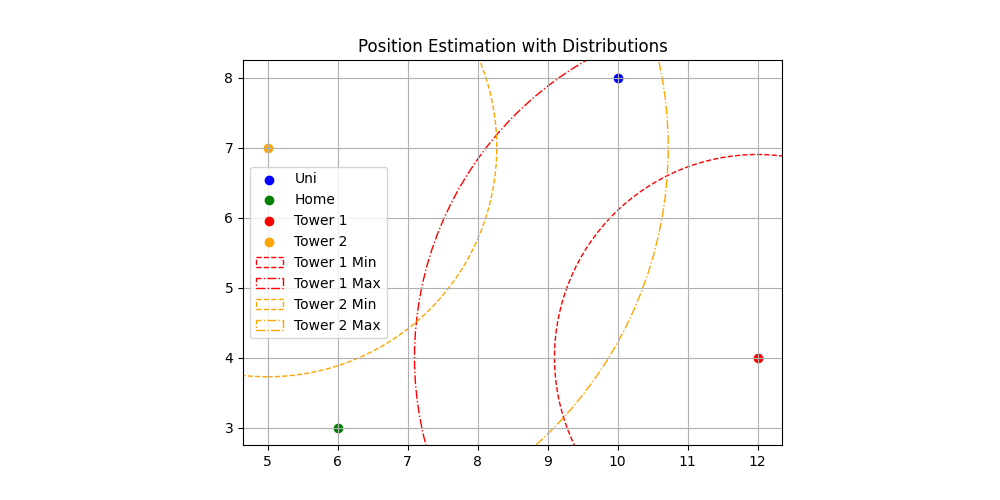

In [1]:
%matplotlib widget

import glm
import math
from matplotlib import pyplot as plt
import numpy as np



m0 = glm.vec2(10, 8)  # Uni
m1 = glm.vec2(6,3)    # Home
t0 = glm.vec2(12, 4)  # Tower 1
t1 = glm.vec2(5, 7)   # Tower 2

sigma1 = 1.0
sigma2 = math.sqrt(1.5)

d1 = 3.9
d2 = 4.5

def draw_circle(ax, center, radius, color, label=None, linestyle='-'):
    circle = plt.Circle((center.x, center.y), radius, color=color, fill=False, linestyle=linestyle, label=label)
    ax.add_artist(circle)

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(m0.x, m0.y, c='blue', label='Uni')
ax.scatter(m1.x, m1.y, c='green', label='Home')
ax.scatter(t0.x, t0.y, c='red', label='Tower 1')
ax.scatter(t1.x, t1.y, c='orange', label='Tower 2')

draw_circle(ax, t0, d1 - sigma1, 'red', 'Tower 1 Min', linestyle='--')
draw_circle(ax, t0, d1 + sigma1, 'red', 'Tower 1 Max', linestyle='-.')

draw_circle(ax, t1, d2 - sigma2, 'orange', 'Tower 2 Min', linestyle='--')
draw_circle(ax, t1, d2 + sigma2, 'orange', 'Tower 2 Max', linestyle='-.')

ax.set_title("Position Estimation with Distributions")
ax.legend()
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
plt.show()

In [2]:
from scipy.stats import norm

def calculate_likelihood(position: glm.vec2):
    d0_true = np.linalg.norm(position - t0)
    d1_true = np.linalg.norm(position - t1)

    likelihood_tower0 = norm.pdf(d1, loc=d0_true, scale=sigma1)
    likelihood_tower1 = norm.pdf(d2, loc=d1_true, scale=sigma2)
    
    return likelihood_tower0 * likelihood_tower1

likelihood_university = calculate_likelihood(m0)
likelihood_home = calculate_likelihood(m1)

print(f"Вероятность нахождения в университете: {likelihood_university:.6f}")
print(f"Вероятность нахождения дома: {likelihood_home:.6f}")
print("Подруга скорее в " "университете" if likelihood_university > likelihood_home else "доме")


Вероятность нахождения в университете: 0.097892
Вероятность нахождения дома: 0.011445
Подруга скорее в университете


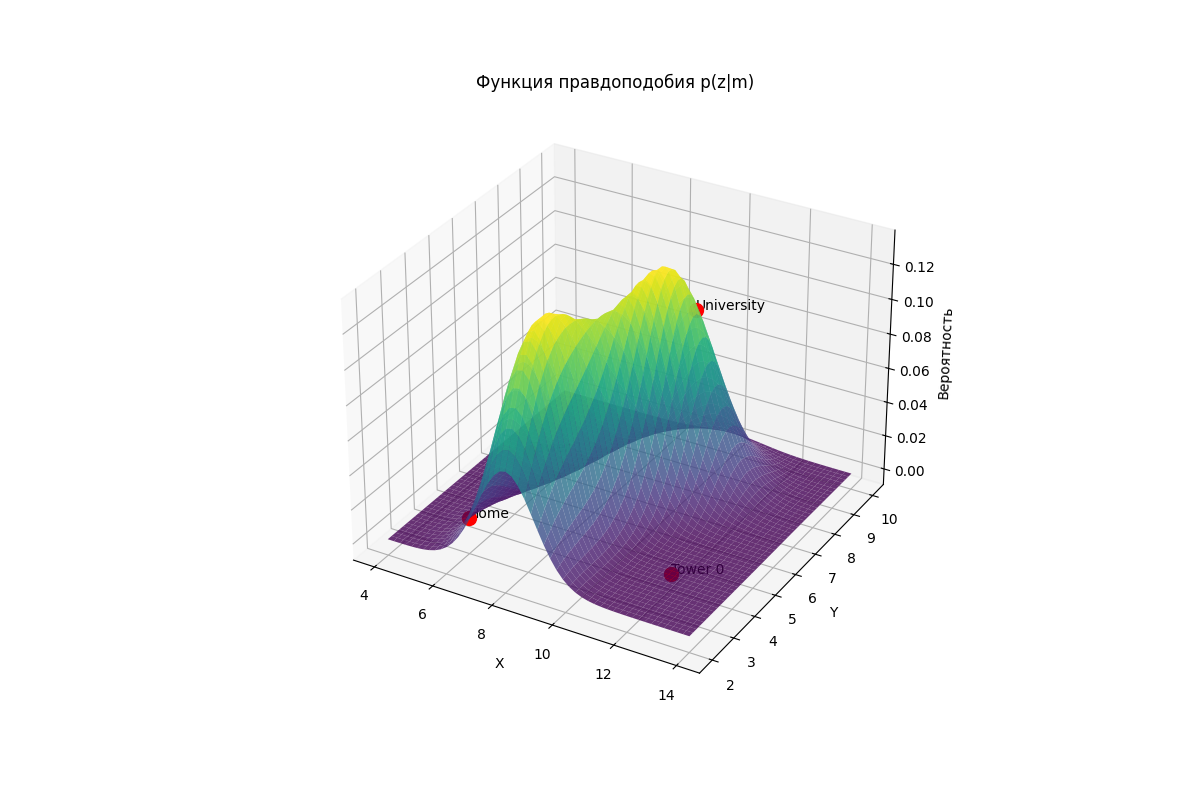

In [3]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(4, 14, 50)
y = np.linspace(2, 10, 50)
X, Y = np.meshgrid(x, y)

Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = calculate_likelihood(np.array([X[i,j], Y[i,j]]))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

points = {'University': m0, 'Home': m1, 'Tower 0': t0, 'Tower 1': t1}
for label, point in points.items():
    ax.scatter(*point, calculate_likelihood(point), color='red', s=100)
    ax.text(*point, calculate_likelihood(point), label, color='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Вероятность')
plt.title('Функция правдоподобия p(z|m)')
plt.show()

Априорная вероятность:
P(Дома) = 0.7
P(В университете) = 0.3
Наблюдение: Сигнал вышек показывает, что она в университете
P(Сигнал "В университете" | В университете) = likelihood_uni (0.09)
P(В университете | Сигнал "В университете") - ?

In [4]:
p_home = 0.7
P_university = 0.3

p_signal = (likelihood_home * p_home + likelihood_university * P_university)
p_home_given_signal = (likelihood_home * p_home) / p_signal
p_university_given_signal = (likelihood_university * P_university) / p_signal
print(f"Обновленная вероятность нахождения в университете: {p_university_given_signal:.6f}")
print(f"Обновленная вероятность нахождения дома: {p_home_given_signal:.6f}")

Обновленная вероятность нахождения в университете: 0.785667
Обновленная вероятность нахождения дома: 0.214333


In [5]:
from math import atan2, pi


def measurement_model(z, x, l, sigma_r, sigma_theta):
    z_r, z_theta = z            # Измеренно расстояние и угол
    robot_x, robot_y = x        # Реальная позиция робота
    landmark_x, landmark_y = l  # Позиция маркера
    
    delta_x = landmark_x - robot_x
    delta_y = landmark_y - robot_y

    true_distance = np.sqrt(delta_x ** 2 + delta_y ** 2)
    true_angle = atan2(delta_y, delta_x)
    
    p_distance = norm.pdf(z_r, loc=true_distance, scale=sigma_r)
    p_angle = norm.pdf(z_theta, loc=true_angle, scale=sigma_theta)
    
    return p_distance * p_angle



Вероятность измерения p(z|x,l): 2.202463


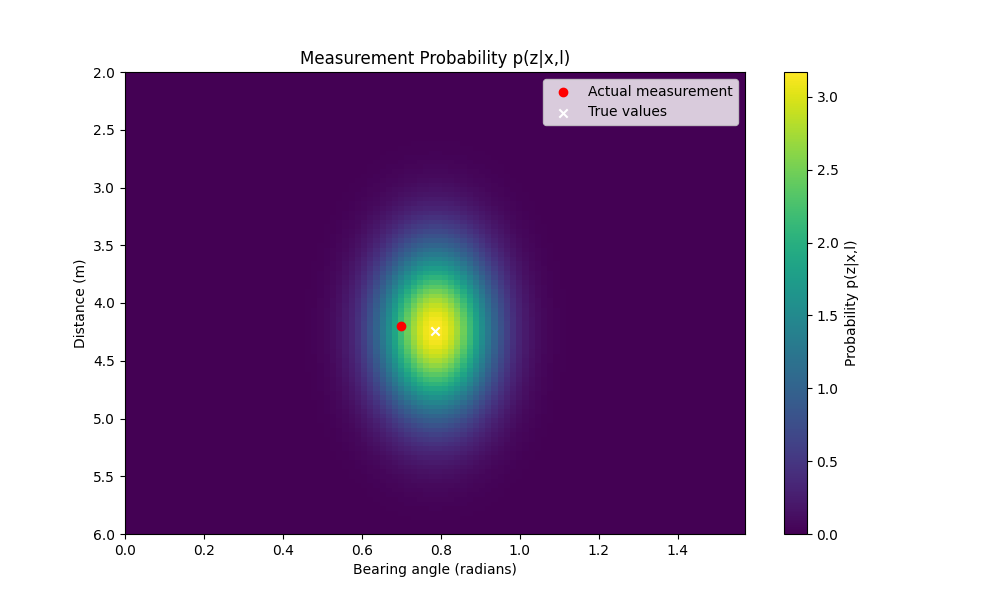

In [6]:

robot_pos = np.array([2.0, 1.0])
landmark_pos = np.array([5.0, 4.0])

measurement = (4.2, 0.7)  

sigma_r = 0.5   
sigma_theta = 0.1

prob = measurement_model(measurement, robot_pos, landmark_pos, sigma_r, sigma_theta)
print(f"Вероятность измерения p(z|x,l): {prob:.6f}")

distances = np.linspace(2, 6, 100)
angles = np.linspace(0, np.pi/2, 100) 

prob_grid = np.zeros((len(distances), len(angles)))
for i, d in enumerate(distances):
    for j, a in enumerate(angles):
        prob_grid[i,j] = measurement_model((d,a), robot_pos, landmark_pos, sigma_r, sigma_theta)

plt.figure(figsize=(10, 6))
plt.imshow(prob_grid, extent=[angles[0], angles[-1], distances[-1], distances[0]], 
            aspect='auto', cmap='viridis')
plt.colorbar(label='Probability p(z|x,l)')
plt.scatter(measurement[1], measurement[0], color='red', label='Actual measurement')

true_dist = np.linalg.norm(landmark_pos - robot_pos)
true_ang = atan2(landmark_pos[1]-robot_pos[1], landmark_pos[0]-robot_pos[0])
plt.scatter(true_ang, true_dist, color='white', marker='x', label='True values')

plt.xlabel('Bearing angle (radians)')
plt.ylabel('Distance (m)')
plt.title('Measurement Probability p(z|x,l)')
plt.legend()
plt.show()